# Case1:The proposed joint optimization framework（no Mask）
Using simulated data

In [7]:
import numpy as np
import scipy.sparse as sp
import osqp
import math
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['Times New Roman', 'SimHei']  
plt.rcParams['axes.unicode_minus']=False  
plt.rcParams.update({
    'font.size': 8,          
    'axes.titlesize': 8,    
    'axes.labelsize': 8,     
    'xtick.labelsize': 8,   
    'ytick.labelsize': 6,    
    'legend.fontsize': 6,    
})


def diff_operator(N, k, dt):
    """Generate an N x N k-th order finite difference matrix (with backward difference at the boundary)."""
    D = np.zeros((N, N))
    # Central difference
    for i in range(N - k):
        for j in range(k + 1):
            D[i, i + j] = (-1)**j * math.comb(k, j)
    # Boundary handling: last k rows use backward difference
    for i in range(N - k, N):
        for j in range(k + 1):
            col = i - (k - j)
            if col >= 0:
                D[i, col] = (-1)**j * math.comb(k, j)
    return D / (dt**k)

def optimize_trajectory_with_velocity(z_x, z_v, dt, λ1=1e-3, λ2=1e-2, λ3=1e-5, verbose=False):
    """
    Trajectory optimization and outlier detection using both position and velocity observations.

    Parameters:
        z_x (np.ndarray): Observed positions (length N)
        z_v (np.ndarray): Observed velocities (length N)
        dt (float): Time step
        λ1, λ2, λ3 (float): Regularization parameters
        verbose (bool): Whether to display solver progress

    Returns:
        dict: Contains optimized results and solver info
    """
    N = len(z_x)
    assert len(z_v) == N, "Position and velocity data must have the same length"
    
    # ===== 1. Construct finite difference operators =====
    D1 = diff_operator(N, 1, dt)  # First derivative (velocity)
    D2 = diff_operator(N, 2, dt)  # Second derivative (acceleration)
    D3 = diff_operator(N, 3, dt)  # Third derivative (jerk)
    
    # ===== 2. Define optimization variables u = [x, v, e_x, e_v, s_x, s_v] =====
    nvar = 6 * N
    I_N = sp.eye(N, format='csc')
    zero = sp.csc_matrix((N, N))
    
    # ===== 3. Build objective matrix P and vector q =====
    P_xx = 2 * I_N + 2 * λ2 * (D2.T @ D2) + 2 * λ3 * (D3.T @ D3)
    P_vv = 2 * I_N
    P_xe = 2 * I_N
    P_ve = 2 * I_N
    
    P = sp.bmat([
        [P_xx,   zero,   P_xe,    zero,    zero,    zero],
        [zero,  P_vv,    zero,   P_ve,    zero,    zero],
        [P_xe.T, zero,  2*I_N,    zero,    zero,    zero],
        [zero,  P_ve.T,  zero,  2*I_N,    zero,    zero],
        [zero,   zero,    zero,    zero,   zero,    zero],
        [zero,   zero,    zero,    zero,   zero,    zero]
    ], format='csc')
    
    q = np.zeros(nvar)
    q[:N] = -2 * z_x
    q[N:2*N] = -2 * z_v
    q[2*N:3*N] = -2 * z_x
    q[3*N:4*N] = -2 * z_v
    q[4*N:5*N] = λ1 * np.ones(N)
    q[5*N:6*N] = λ1 * np.ones(N)
    
    # ===== 4. Build constraints =====
    A_phys = sp.hstack([-D1, -I_N, zero, zero, zero, zero], format='csc')
    l_phys = u_phys = np.zeros(N)

    A_vel = sp.hstack([-D1, zero, zero, zero, zero, zero], format='csc')
    l_vel, u_vel = np.zeros(N), np.inf*np.ones(N)

    A_acc_pos = sp.hstack([D2, zero, zero, zero, zero, zero], format='csc')
    A_acc_neg = sp.hstack([-D2, zero, zero, zero, zero, zero], format='csc')
    l_acc = np.concatenate([-np.inf*np.ones(N), -np.inf*np.ones(N)])
    u_acc = np.concatenate([10*np.ones(N), 10*np.ones(N)])

    A_jerk_pos = sp.hstack([D3, zero, zero, zero, zero, zero], format='csc')
    A_jerk_neg = sp.hstack([-D3, zero, zero, zero, zero, zero], format='csc')
    l_jerk = np.concatenate([-np.inf*np.ones(N), -np.inf*np.ones(N)])
    u_jerk = np.concatenate([10*np.ones(N), 10*np.ones(N)])

    A_ex_neg = sp.hstack([zero, zero, -I_N, zero, I_N, zero], format='csc')
    A_ex_pos = sp.hstack([zero, zero, I_N, zero, I_N, zero], format='csc')
    A_ev_neg = sp.hstack([zero, zero, zero, -I_N, zero, I_N], format='csc')
    A_ev_pos = sp.hstack([zero, zero, zero, I_N, zero, I_N], format='csc')
    l_l1 = np.zeros(4*N)
    u_l1 = np.inf * np.ones(4*N)

    A = sp.vstack([
        A_phys,
        A_vel,
        A_acc_pos, A_acc_neg,
        A_jerk_pos, A_jerk_neg,
        A_ex_neg, A_ex_pos,
        A_ev_neg, A_ev_pos
    ], format='csc')
    l = np.hstack([l_phys, l_vel, l_acc, l_jerk, l_l1])
    u = np.hstack([u_phys, u_vel, u_acc, u_jerk, u_l1])
    
    # ===== 5. Solve using OSQP =====
    prob = osqp.OSQP()
    prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=verbose)
    res = prob.solve()
    
    # ===== 6. Extract results =====
    x_opt = res.x[:N]
    v_opt = res.x[N:2*N]
    e_x_opt = res.x[2*N:3*N]
    e_v_opt = res.x[3*N:4*N]
    
    return {
        'x': x_opt,
        'v': v_opt,
        'e_x': e_x_opt,
        'e_v': e_v_opt,
        'info': res.info
    }

def plot_joint_results(t, z_x, z_v, result, dt, x_true=None, v_true=None):
    """
    Visualize joint optimization results (4-subplot layout).

    Parameters:
        t: Time vector (length N)
        z_x: Observed positions
        z_v: Observed velocities
        result: Dictionary returned by optimize_trajectory_with_velocity
        dt: Time step
        x_true: Ground truth positions (optional)
        v_true: Ground truth velocities (optional)
    """
    x_opt = result['x']
    v_opt = result['v']
    e_x = result['e_x']
    e_v = result['e_v']

    def safe_gradient(data):
        grad = np.gradient(data, dt)
        grad[0] = (data[1] - data[0]) / dt
        grad[-1] = (data[-1] - data[-2]) / dt
        return grad

    a_opt = safe_gradient(v_opt)
    z_a = safe_gradient(z_v)

    plt.figure(figsize=(8, 8))

    ax1 = plt.subplot(4, 1, 1)
    if x_true is not None:
        ax1.plot(t, x_true, 'k--', label='True Position', lw=2)
    ax1.plot(t, z_x, 'ro', markersize=4, alpha=0.6, label='Observed Position')
    ax1.plot(t, x_opt, 'b-', lw=1.5, label='Recovered Position')
    ax1.set_ylabel('Position (m)')
    ax1.legend(loc='upper right')
    ax1.grid(True, ls='--', alpha=0.3)

    ax2 = plt.subplot(4, 1, 2, sharex=ax1)
    if v_true is not None:
        ax2.plot(t, v_true, 'k--', label='True Velocity', lw=2)
    ax2.plot(t, z_v, 'g^', markersize=4, alpha=0.6, label='Observed Velocity')
    ax2.plot(t, v_opt, 'm-', lw=1.5, label='Recovered Velocity')
    ax2.set_ylabel('Velocity (m/s)')
    ax2.legend(loc='upper right')
    ax2.grid(True, ls='--', alpha=0.3)

    ax3 = plt.subplot(4, 1, 3, sharex=ax1)
    if v_true is not None:
        a_true = safe_gradient(v_true)
        ax3.plot(t, a_true, 'k--', label='True Acceleration', lw=2)
    ax3.plot(t, z_a, 'ys', markersize=4, alpha=0.6, label='Observed Acceleration')
    ax3.plot(t, a_opt, 'c-', lw=1.5, label='Recovered Acceleration')
    ax3.set_ylabel('Acceleration (m/s²)')
    ax3.legend(loc='upper right')
    ax3.grid(True, ls='--', alpha=0.3)

    ax4 = plt.subplot(4, 1, 4, sharex=ax1)
    ax4.plot(t, e_x, 'r-', label='Position Error')
    ax4.plot(t, e_v, 'b-', label='Velocity Error')
    ax4.set_ylabel('Error')
    ax4.set_xlabel('Time (s)')
    ax4.legend(loc='upper right')
    ax4.grid(True, ls='--', alpha=0.3)

    plt.tight_layout()
    plt.show()


-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 600, constraints m = 1000
          nnz(P) + nnz(A) = 3594
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
          scaling: on (10 iterations), scaled_termination: off
          warm starting: on, polishing: off, 
iter   objective    prim res   dual res   gap        rel kkt    rho         time
   1  -2.7289e+05   4.67e+00   6.57e+02   1.01e+05   1

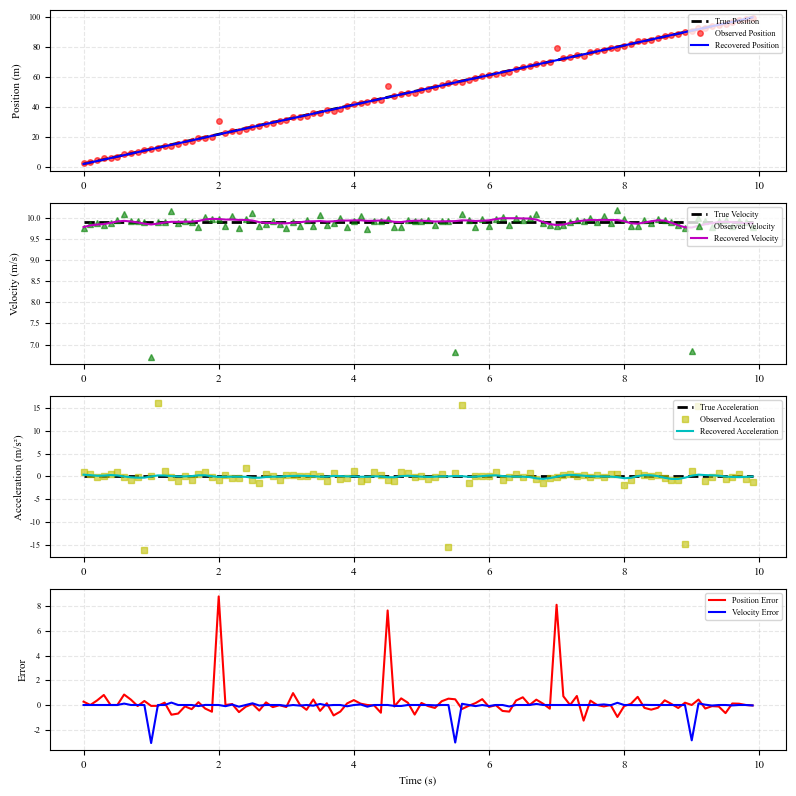

In [8]:
# ===== Example Usage =====
if __name__ == "__main__":
    # Generate simulated data
    np.random.seed(42)
    N = 100
    dt = 0.1
    t = np.arange(N) * dt

    # Ground truth trajectory (a sine-like curve)
    x_true = np.linspace(2, 100, N)
    v_true = np.gradient(x_true, dt)

    # Add noise and outliers
    z_x = x_true + np.random.normal(0, 0.5, N)
    z_v = v_true + np.random.normal(0, 0.1, N)
    z_x[[20, 45, 70]] += 8   # Position outliers
    z_v[[10, 55, 90]] -= 3   # Velocity outliers

    # Run optimization
    result = optimize_trajectory_with_velocity(
        z_x, z_v, dt,
        # λ1=1,   # Controls sparsity of outliers
        # λ2=1,   # Acceleration regularization
        # λ3=1,   # Jerk regularization
        λ1=1e-1,   # Controls sparsity of outliers
        λ2=1e-3,   # Acceleration regularization
        λ3=1e-4,   # Jerk regularization
        verbose=True
    )

    # Visualization
    plot_joint_results(t, z_x, z_v, result, dt, x_true=x_true, v_true=v_true)

## Further visualization

-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 600, constraints m = 1000
          nnz(P) + nnz(A) = 3594
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
          scaling: on (10 iterations), scaled_termination: off
          warm starting: on, polishing: off, 
iter   objective    prim res   dual res   gap        rel kkt    rho         time
   1  -2.8695e+05   4.60e+00   6.54e+02   1.07e+05   1

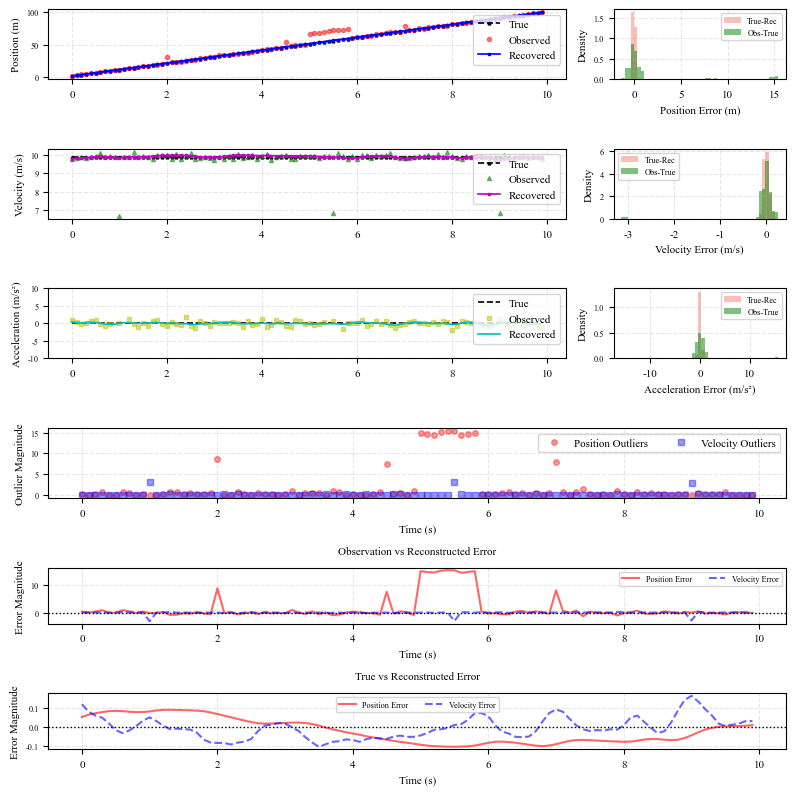

Original velocity z_v distribution statistics:
  min  : 6.7071
  max  : 10.1710
  mean : 9.8112
  std  : 0.5383
--------------------------------------------------
Original acceleration z_a distribution statistics:
  min  : -16.0882
  max  : 15.9895
  mean : 0.0017
  std  : 3.8691
--------------------------------------------------
Optimized velocity v_opt distribution statistics:
  min  : 9.7320
  max  : 10.0057
  mean : 9.9030
  std  : 0.0574
--------------------------------------------------
Optimized acceleration a_opt distribution statistics:
  min  : -0.6065
  max  : 0.4081
  mean : 0.0111
  std  : 0.2183
--------------------------------------------------
Original acceleration z_a acceleration analysis:
  Proportion of abnormal accelerations (|a| > 10): 6.00%
  Proportion of abnormal jerks (|jerk| > 15): 10.00%
  Proportion of 1s windows with sign changes in jerk: 100.00%
--------------------------------------------------
True acceleration z_a acceleration analysis:
  Proportion of

In [27]:
def process_plot_data(t, z_x, z_v, result, dt, x_true=None, v_true=None):
    """
    Preprocess all data required for plotting
    
    Parameters:
        t: Time sequence (length N)
        z_x: Observed position data
        z_v: Observed velocity data
        result: Optimization result dictionary
        dt: Time step
        v_true: True velocity (optional)
        
    Returns:
        plot_data: Dictionary containing all plotting data
    """
    # Extract optimization results
    x_opt = result['x']
    v_opt = result['v']
    e_x = result['e_x']
    e_v = result['e_v']

    # Define safe gradient calculation
    def safe_gradient(data):
        grad = np.gradient(data, dt)
        grad[0] = (data[1] - data[0]) / dt  # Forward difference for the first point
        grad[-1] = (data[-1] - data[-2]) / dt  # Backward difference for the last point
        return grad

    # Calculate acceleration data
    a_opt = safe_gradient(v_opt)
    z_a = safe_gradient(z_v)
    
    # Preprocess true acceleration (if exists)
    a_true = None
    if v_true is not None:
        a_true = safe_gradient(v_true)

    # Calculate observation errors (requires true values)
    obs_errors = {
        'x': z_x - x_true if x_true is not None else None,
        'v': z_v - v_true if v_true is not None else None,
        'a': z_a - a_true if (a_true is not None and x_true is not None) else None
    }

    return {
        't': t,
        'raw': {'x': z_x, 'v': z_v, 'a': z_a},
        'optimized': {'x': x_opt, 'v': v_opt, 'a': a_opt},
        'true': {'x': x_true, 'v': v_true, 'a': a_true},
        'errors': {'x': e_x, 'v': e_v},
        'obs_errors': obs_errors  # Observation error data
    }


def print_stats(name, data):
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    std_val = np.std(data)

    print(f"{name} distribution statistics:")
    print(f"  min  : {min_val:.4f}")
    print(f"  max  : {max_val:.4f}")
    print(f"  mean : {mean_val:.4f}")
    print(f"  std  : {std_val:.4f}")
    print("-" * 50)

    return min_val, max_val, mean_val, std_val

def analyze_acceleration(name, a, dt, ifprint=True):
    jerk = np.gradient(a, dt)
    
    # Proportion of abnormal accelerations
    acc_abnormal_ratio = np.sum(np.abs(a) > 10) / len(a)
    
    # Proportion of abnormal jerks
    jerk_abnormal_ratio = np.sum(np.abs(jerk) > 15) / len(jerk)
    
    # Whether there is a sign change within a 1s window
    window_size = int(1 / dt)
    unstable_window_count = 0
    total_window_count = len(jerk) - window_size
    
    for i in range(total_window_count):
        window = jerk[i:i + window_size]
        sign_changes = np.sum(np.diff(np.sign(window)) != 0)
        if sign_changes >= 1:
            unstable_window_count += 1
    
    unstable_ratio = unstable_window_count / total_window_count
    
    if ifprint:
        print(f"{name} acceleration analysis:")
        print(f"  Proportion of abnormal accelerations (|a| > 10): {acc_abnormal_ratio * 100:.2f}%")
        print(f"  Proportion of abnormal jerks (|jerk| > 15): {jerk_abnormal_ratio * 100:.2f}%")
        print(f"  Proportion of 1s windows with sign changes in jerk: {unstable_ratio * 100:.2f}%")
        print("-" * 50)
    return acc_abnormal_ratio, jerk_abnormal_ratio

def trajectory_distribution(plot_data):
    """
    Complete visualization of optimization results, including dual error analysis
    
    Parameters:
        plot_data: Data dictionary returned by process_plot_data
        figsize: Chart size
    """
    # Unpack data
    t = plot_data['t']
    z_x = plot_data['raw']['x']
    z_v = plot_data['raw']['v']
    z_a = plot_data['raw']['a']
    x_opt = plot_data['optimized']['x']
    v_opt = plot_data['optimized']['v']
    a_opt = plot_data['optimized']['a']
    e_x = plot_data['errors']['x']
    e_v = plot_data['errors']['v']
    x_true = plot_data['true']['x']
    v_true = plot_data['true']['v']
    a_true = plot_data['true']['a']

    # Get statistical metrics
    z_v_stats = print_stats("Original velocity z_v", z_v)
    z_a_stats = print_stats("Original acceleration z_a", z_a)
    v_opt_stats = print_stats("Optimized velocity v_opt", v_opt)
    a_opt_stats = print_stats("Optimized acceleration a_opt", a_opt)

    # Get acceleration and jerk quality analysis results
    z_a_anomal, z_jerk_anomal = analyze_acceleration("Original acceleration z_a", z_a, dt)
    z_a_true, z_jerk_true = analyze_acceleration("True acceleration z_a", a_true, dt) if (a_true is not None) else None
    a_opt_anomal, jerk_opt_anomal = analyze_acceleration("Optimized acceleration a_opt", a_opt, dt)

    # Package all results into a dictionary (for easy conversion to DataFrame)
    result = {
        "z_v_min": z_v_stats[0], "z_v_max": z_v_stats[1], "z_v_mean": z_v_stats[2], "z_v_std": z_v_stats[3],
        "z_a_min": z_a_stats[0], "z_a_max": z_a_stats[1], "z_a_mean": z_a_stats[2], "z_a_std": z_a_stats[3],
        "v_opt_min": v_opt_stats[0], "v_opt_max": v_opt_stats[1], "v_opt_mean": v_opt_stats[2], "v_opt_std": v_opt_stats[3],
        "a_opt_min": a_opt_stats[0], "a_opt_max": a_opt_stats[1], "a_opt_mean": a_opt_stats[2], "a_opt_std": a_opt_stats[3],
        "z_a_anomal": z_a_anomal, "z_jerk_anomal": z_jerk_anomal,
        "a_opt_anomal": a_opt_anomal, "jerk_opt_anomal": jerk_opt_anomal
    }

    return result



def plot_optimization_results(plot_data, plot=True, figsize=(10, 6)):
    """
    Complete visualization of optimization results, including dual error analysis
    
    Parameters:
        plot_data: Data dictionary returned by process_plot_data
        figsize: Chart size
    """
    # Unpack data
    t = plot_data['t']
    z_x = plot_data['raw']['x']
    z_v = plot_data['raw']['v']
    z_a = plot_data['raw']['a']
    x_opt = plot_data['optimized']['x']
    v_opt = plot_data['optimized']['v']
    a_opt = plot_data['optimized']['a']
    e_x = plot_data['errors']['x']
    e_v = plot_data['errors']['v']
    x_true = plot_data['true']['x']
    v_true = plot_data['true']['v']
    a_true = plot_data['true']['a']

    # Calculate two types of errors
    error_obs_x = z_x - x_opt  # Observed vs Reconstructed
    error_obs_v = z_v - v_opt
    error_obs_a = z_a - a_opt
    
    error_true_x = x_true - x_opt if x_true is not None else None  # True vs Reconstructed
    error_true_v = v_true - v_opt if v_true is not None else None
    error_true_a = a_true - a_opt if a_true is not None else None

    error_obs_true_x = z_x - x_true if x_true is not None else None  # True vs Observed
    error_obs_true_v = z_v - v_true if v_true is not None else None
    error_obs_true_a = z_a - a_true if a_true is not None else None

    if plot:
        plt.figure(figsize=figsize)
        gs = plt.GridSpec(6, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1, 1, 0.8, 0.8])
        
        # 1. Position comparison (main plot + dual error distribution)
        ax1 = plt.subplot(gs[0, 0])
        _plot_comparison(ax1, t, z_x, x_opt, x_true,
                        'Position (m)', 'Observed', 'Recovered', 'True',
                        'ro', 'b-s', 'k--^')
        
        ax1_hist = plt.subplot(gs[0, 1])
        _plot_dual_error_distribution(ax1_hist, error_obs_x, error_true_x, error_obs_true_x,
                                    'Position Error (m)', ['Obs-Rec', 'True-Rec', 'Obs-True'])

        # 2. Velocity comparison (main plot + dual error distribution)
        ax2 = plt.subplot(gs[1, 0], sharex=ax1)
        _plot_comparison(ax2, t, z_v, v_opt, v_true,
                        'Velocity (m/s)', 'Observed', 'Recovered', 'True',
                        'g^', 'm-s', 'k--^')
        
        ax2_hist = plt.subplot(gs[1, 1])
        _plot_dual_error_distribution(ax2_hist, error_obs_v, error_true_v, error_obs_true_v,
                                    'Velocity Error (m/s)', ['Obs-Rec', 'True-Rec', 'Obs-True'])

        # 3. Acceleration comparison (main plot + dual error distribution)
        ax3 = plt.subplot(gs[2, 0], sharex=ax1)
        _plot_comparison(ax3, t, z_a, a_opt, a_true,
                        'Acceleration (m/s²)', 'Observed', 'Recovered', 'True',
                        'ys', 'c-', 'k--')
        ax3.set_ylim(-10, 10)
        
        ax3_hist = plt.subplot(gs[2, 1])
        _plot_dual_error_distribution(ax3_hist, error_obs_a, error_true_a, error_obs_true_a,
                                    'Acceleration Error (m/s²)', ['Obs-Rec', 'True-Rec', 'Obs-True'])

        # 4. Outlier detection
        ax4 = plt.subplot(gs[3, :])
        _plot_errors(ax4, t, e_x, e_v)

        # 5. Observation vs Reconstructed error evolution
        ax5 = plt.subplot(gs[4, :])
        _plot_error_evolution(ax5, t, error_obs_x, error_obs_v,
                            title='Observation vs Reconstructed Error')

        # 6. True vs Reconstructed error evolution (if true values exist)
        ax6 = plt.subplot(gs[5, :])
        if error_true_x is not None:
            _plot_error_evolution(ax6, t, error_true_x, error_true_v,
                                title='True vs Reconstructed Error')
        else:
            ax6.text(0.5, 0.5, 'No ground truth data available', 
                    ha='center', va='center')
            ax6.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Basic statistical metrics
    try:
        x_m = abs(error_true_x).mean()
        v_m = abs(error_true_v).mean()
        a_m = abs(error_true_a).mean()

    except:
        x_m = None
        v_m = None
        a_m = None
    # Add an average return value here
    return x_m, v_m


def _plot_dual_error_distribution(ax, error_obs, error_true, error_obs_true, xlabel, labels):
    """Plot dual error distribution comparison"""
    bins = np.linspace(min(np.min(error_obs), 
                         np.min(error_true) if error_true is not None else np.min(error_obs)),
                      max(np.max(error_obs),
                         np.max(error_true) if error_true is not None else np.max(error_obs)), 
                      50)
    
    # ax.hist(error_obs, bins=bins, color='steelblue', alpha=0.5, 
    #         density=True, label=labels[0])
    
    if error_true is not None:
        ax.hist(error_true, bins=bins, color='salmon', alpha=0.5,
                density=True, label=labels[1])
        
        print_stats("True vs Reconstructed error_true" + xlabel, error_true)    
        
    
    if error_obs_true is not None:
        ax.hist(error_obs_true, bins=bins, color='green', alpha=0.5,
                density=True, label=labels[2])
        print_stats("True vs Observed error_obs_true" + xlabel, error_obs_true)  
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, ls='--', alpha=0.3)


def _plot_error_evolution(ax, t, error_x, error_v, title=None):
    """Enhanced error evolution curve"""
    ax.plot(t, error_x, 'r-', alpha=0.6, label='Position Error')
    ax.plot(t, error_v, 'b--', alpha=0.6, label='Velocity Error')
    ax.axhline(0, color='k', linestyle=':', lw=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Error Magnitude')
    if title:
        ax.set_title(title, pad=10)
    ax.legend(loc='upper right')
    ax.grid(True, ls='--', alpha=0.3)
    
    ax.legend(ncol=2)

# Retain the original _plot_comparison and _plot_errors functions

def _plot_comparison(ax, t, observed, optimized, true, 
                    ylabel, obs_label, opt_label, true_label,
                    obs_style, opt_style, true_style):
    """Enhanced comparison plotting template"""
    if true is not None:
        ax.plot(t, true, true_style, markersize=2, label=true_label, lw=1.2)
    ax.plot(t, observed, obs_style, markersize=3, alpha=0.5, label=obs_label)
    ax.plot(t, optimized, opt_style, markersize=2, lw=1.2, label=opt_label)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, ls='--', alpha=0.3)

def _plot_errors(ax, t, e_x, e_v):
    """Enhanced outlier plotting template"""
    ax.plot(t, np.abs(e_x), 'ro', markersize=4, alpha=0.4, label='Position Outliers')
    ax.plot(t, np.abs(e_v), 'bs', markersize=4, alpha=0.4, label='Velocity Outliers')
    ax.set_ylabel('Outlier Magnitude')
    ax.set_xlabel('Time (s)')
    ax.legend(ncol=2, loc='upper right', fontsize=8)
    ax.grid(True, ls='--', alpha=0.3)


# ===== Example Usage =====
if __name__ == "__main__":
    # Generate simulated data
    np.random.seed(42)
    N = 100
    dt = 0.1
    t = np.arange(N) * dt
    
    # True trajectory (linear)
    x_true = np.linspace(2, 100, N)
    v_true = np.gradient(x_true, dt)
    
    # Add noise and outliers
    z_x = x_true + np.random.normal(0, 0.5, N)
    z_v = v_true + np.random.normal(0, 0.1, N)
    z_x[[20, 45, 70]] += 8  # Position outliers
    z_x[range(50,59)] += 15  # fixed Position outliers
    z_v[[10, 55, 90]] -= 3  # Velocity outliers
    
    # Run optimization
    result = optimize_trajectory_with_velocity(
        z_x, z_v, dt, 
        # λ1=1,   # Control outlier sparsity
        # λ2=1,  # Acceleration regularization
        # λ3=1,  # Jerk regularization
        λ1=1e-1,   # Control outlier sparsity
        λ2=1e-3,  # Acceleration regularization
        λ3=1e-4,  # Jerk regularization
        verbose=True
    )
    
    # Visualization
    plot_data = process_plot_data(t, z_x, z_v, result, dt, x_true=x_true, v_true=v_true)
    plot_optimization_results(plot_data, figsize=(8, 8))

    # Check statistical metrics
    trajectory_distribution(plot_data)

# Case2:The proposed joint optimization framework（+ Mask）
Using simulated data

-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 600, constraints m = 1000
          nnz(P) + nnz(A) = 3564
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
          scaling: on (10 iterations), scaled_termination: off
          warm starting: on, polishing: off, 
iter   objective    prim res   dual res   gap        rel kkt    rho         time
   1  -7.2965e+04   7.50e+00   5.08e+02  -6.80e+04   5

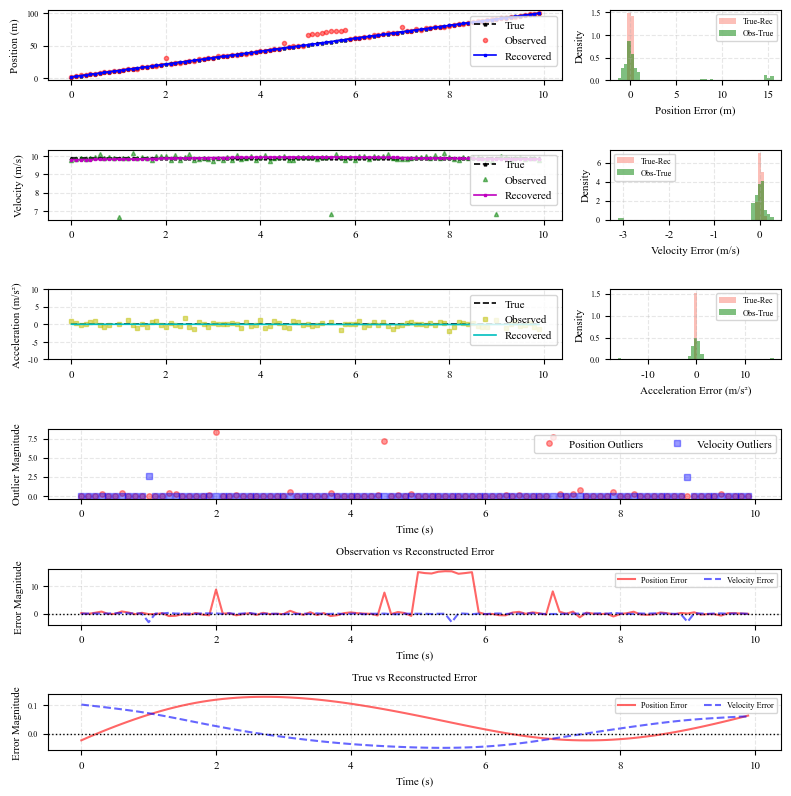

Original velocity z_v distribution statistics:
  min  : 6.7071
  max  : 10.1710
  mean : 9.8112
  std  : 0.5383
--------------------------------------------------
Original acceleration z_a distribution statistics:
  min  : -16.0882
  max  : 15.9895
  mean : 0.0017
  std  : 3.8691
--------------------------------------------------
Optimized velocity v_opt distribution statistics:
  min  : 9.7972
  max  : 9.9476
  mean : 9.8898
  std  : 0.0451
--------------------------------------------------
Optimized acceleration a_opt distribution statistics:
  min  : -0.0362
  max  : 0.0467
  mean : 0.0043
  std  : 0.0285
--------------------------------------------------
Original acceleration z_a acceleration analysis:
  Proportion of abnormal accelerations (|a| > 10): 6.00%
  Proportion of abnormal jerks (|jerk| > 15): 10.00%
  Proportion of 1s windows with sign changes in jerk: 100.00%
--------------------------------------------------
True acceleration z_a acceleration analysis:
  Proportion of 

In [29]:
def optimize_trajectory_with_velocity_mask_scale(z_x, z_v, dt, λ1=1e-3, λ2=1e-2, λ3=1e-5, 
                                     weight_x=None, weight_v=None, verbose=False):
    """
    Trajectory optimization and outlier detection with joint position and velocity observations (In practice, I only did scaling)
    
    Parameters:
        z_x (np.ndarray): Position observation data (length N)
        z_v (np.ndarray): Velocity observation data (length N)
        dt (float): Time step
        λ1, λ2, λ3 (float): Regularization parameters
        weight_x (np.ndarray): Position observation weights (between 0 and 1, 0 indicates full trust in constraints)
        weight_v (np.ndarray): Velocity observation weights (same as above)
        verbose (bool): Whether to display the solving process
        
    Returns:
        dict: Contains optimization results and solving information
    """
    N = len(z_x)
    assert len(z_v) == N, "The lengths of position and velocity data must be consistent"
    
    # Handle default weights
    weight_x = np.ones(N) if weight_x is None else weight_x
    weight_v = np.ones(N) if weight_v is None else weight_v
    
    # Key scaling weights, used to balance the pressure brought by long trajectory length to data optimization
    # scale_x = 1.0 / 100 # Scale the trajectory length to a similar range

    # Normalize and scale the weights, keeping the mask positions at 0
    # weight_x = scale_x * (weight_x > 0).astype(float) # Scaling only X might be better


    # ===== 1. Construct weight matrices =====
    Wx = sp.diags(weight_x, format='csc')  # Position weight diagonal matrix
    Wv = sp.diags(weight_v, format='csc')  # Velocity weight diagonal matrix
    
    # ===== 2. Construct NxN difference operators =====
    D1 = diff_operator(N, 1, dt)  # Velocity operator (N x N)
    D2 = diff_operator(N, 2, dt)  # Acceleration operator (N x N)
    D3 = diff_operator(N, 3, dt)  # Jerk operator (N x N)
    
    # ===== 3. Define optimization variables u = [x (N), v (N), e_x (N), e_v (N), s_x (N), s_v (N)] =====
    nvar = 6 * N
    I_N = sp.eye(N, format='csc')
    zero = sp.csc_matrix((N, N))
    
    # ===== 4. Construct objective function matrix P and vector q =====
    # Block structure of P matrix (6x6 blocks)
    P_xx = 2 * Wx + 2 * λ2 * (D2.T @ D2) + 2 * λ3 * (D3.T @ D3)
    P_vv = 2 * Wv
    P_xe = 2 * Wx  # Cross-term between x and e_x
    P_ve = 2 * Wv  # Cross-term between v and e_v
    
    P = sp.bmat([
        [P_xx,   zero,   P_xe,    zero,    zero,    zero],
        [zero,  P_vv,    zero,   P_ve,    zero,    zero],
        [P_xe.T, zero,  2*I_N,    zero,    zero,    zero],
        [zero,  P_ve.T,  zero,  2*I_N,    zero,    zero],
        [zero,   zero,    zero,    zero,   zero,    zero],
        [zero,   zero,    zero,    zero,   zero,    zero]
    ], format='csc')
    
    # q vector (6*N dimensions)
    q = np.zeros(nvar)
    q[:N] = -2 * Wx @ z_x          # x term (weighted)
    q[N:2*N] = -2 * Wv @ z_v       # v term (weighted)
    q[2*N:3*N] = -2 * Wx @ z_x     # e_x term (weighted)
    q[3*N:4*N] = -2 * Wv @ z_v     # e_v term (weighted)
    q[4*N:5*N] = λ1 * np.ones(N)   # s_x term
    q[5*N:6*N] = λ1 * np.ones(N)   # s_v term
    
    # ===== 5. Construct constraints =====
    # Physical constraint v = D1 x (N equations)
    A_phys = sp.hstack([-D1, -I_N, zero, zero, zero, zero], format='csc')
    l_phys = u_phys = np.zeros(N)

    # Non-negative velocity constraint (D1x ≥ 0)
    A_vel = sp.hstack([-D1, zero, zero, zero, zero, zero], format='csc')
    l_vel, u_vel = np.zeros(N), np.inf*np.ones(N)

    # Acceleration constraint |D2 x| <= 10 (2N equations)
    A_acc_pos = sp.hstack([D2, zero, zero, zero, zero, zero], format='csc')
    A_acc_neg = sp.hstack([-D2, zero, zero, zero, zero, zero], format='csc')
    l_acc = np.concatenate([-np.inf*np.ones(N), -np.inf*np.ones(N)])
    u_acc = np.concatenate([10*np.ones(N), 10*np.ones(N)])
    
    # Jerk constraint |D3 x| <= 10 (2N equations)
    A_jerk_pos = sp.hstack([D3, zero, zero, zero, zero, zero], format='csc')
    A_jerk_neg = sp.hstack([-D3, zero, zero, zero, zero, zero], format='csc')
    l_jerk = np.concatenate([-np.inf*np.ones(N), -np.inf*np.ones(N)])
    u_jerk = np.concatenate([10*np.ones(N), 10*np.ones(N)])
    
    # L1 constraint s >= |e| (4N equations)
    A_ex_neg = sp.hstack([zero, zero, -I_N, zero, I_N, zero], format='csc')  # s_x - e_x >= 0
    A_ex_pos = sp.hstack([zero, zero, I_N, zero, I_N, zero], format='csc')   # s_x + e_x >= 0
    A_ev_neg = sp.hstack([zero, zero, zero, -I_N, zero, I_N], format='csc')  # s_v - e_v >= 0
    A_ev_pos = sp.hstack([zero, zero, zero, I_N, zero, I_N], format='csc')   # s_v + e_v >= 0
    l_l1 = np.zeros(4*N)
    u_l1 = np.inf * np.ones(4*N)
    
    # Combine all constraints
    A = sp.vstack([
        A_phys,
        A_vel,
        A_acc_pos, A_acc_neg,
        A_jerk_pos, A_jerk_neg,
        A_ex_neg, A_ex_pos,
        A_ev_neg, A_ev_pos
    ], format='csc')
    l = np.hstack([l_phys, l_vel, l_acc, l_jerk, l_l1])
    u = np.hstack([u_phys, u_vel, u_acc, u_jerk, u_l1])
    
    # ===== 6. OSQP solving =====
    prob = osqp.OSQP()
    prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=verbose)
    res = prob.solve()
    
    # ===== 7. Extract results =====
    x_opt = res.x[:N]
    v_opt = res.x[N:2*N]
    e_x_opt = res.x[2*N:3*N]
    e_v_opt = res.x[3*N:4*N]
    
    return {
        'x': x_opt,
        'v': v_opt,
        'e_x': e_x_opt,
        'e_v': e_v_opt,
        'info': res.info
    }


# ===== Example Usage =====
if __name__ == "__main__":
    # Generate simulated data
    np.random.seed(42)
    N = 100
    dt = 0.1
    t = np.arange(N) * dt
    
    # True trajectory (linear)
    x_true = np.linspace(2, 100, N)
    v_true = np.gradient(x_true, dt)
    
    # Add noise and outliers
    z_x = x_true + np.random.normal(0, 0.5, N)
    z_v = v_true + np.random.normal(0, 0.1, N)
    z_x[[20, 45, 70]] += 8  # Position outliers
    z_x[range(50,59)] += 15  # Fixed position outliers
    z_v[[10, 55, 90]] -= 3  # Velocity outliers
    
    # Mark points to be interpolated (indices 50-59 set as missing)
    missing_idx = np.arange(50, 60)
    # z_x[missing_idx] = 0 # Can also not mark as 0
    # z_v[missing_idx] = 0

    # Set weights (weights for missing points are 0)
    weight_x = np.ones(N)
    weight_x[missing_idx] = 0
    weight_v = np.ones(N)
    weight_v[missing_idx] = 0

    # Run optimization
    result = optimize_trajectory_with_velocity_mask_scale(
        z_x, z_v, dt, 
        λ1=1,   # Control outlier sparsity
        λ2=1,  # Acceleration regularization
        λ3=1,  # Jerk regularization
        # λ1=1e-1,   # Control outlier sparsity
        # λ2=1e-3,  # Acceleration regularization
        # λ3=1e-4,  # Jerk regularization
        weight_x=weight_x, weight_v=weight_v,
        verbose=True
    )
    
    # Visualization
    plot_data = process_plot_data(t, z_x, z_v, result, dt, x_true=x_true, v_true=v_true)
    plot_optimization_results(plot_data, figsize=(8, 8))

    # Check statistical metrics
    trajectory_distribution(plot_data)